# Interpolation and FPS Adjustment

## 🎯 What is the Different FPS Problem?

**The Problem:**
- Video 1: 30 FPS (30 frames per second)
- Video 2: 24 FPS
- Video 3: 60 FPS
- Video 4: 25 FPS

**To train a model, we need a unified FPS for all videos.**

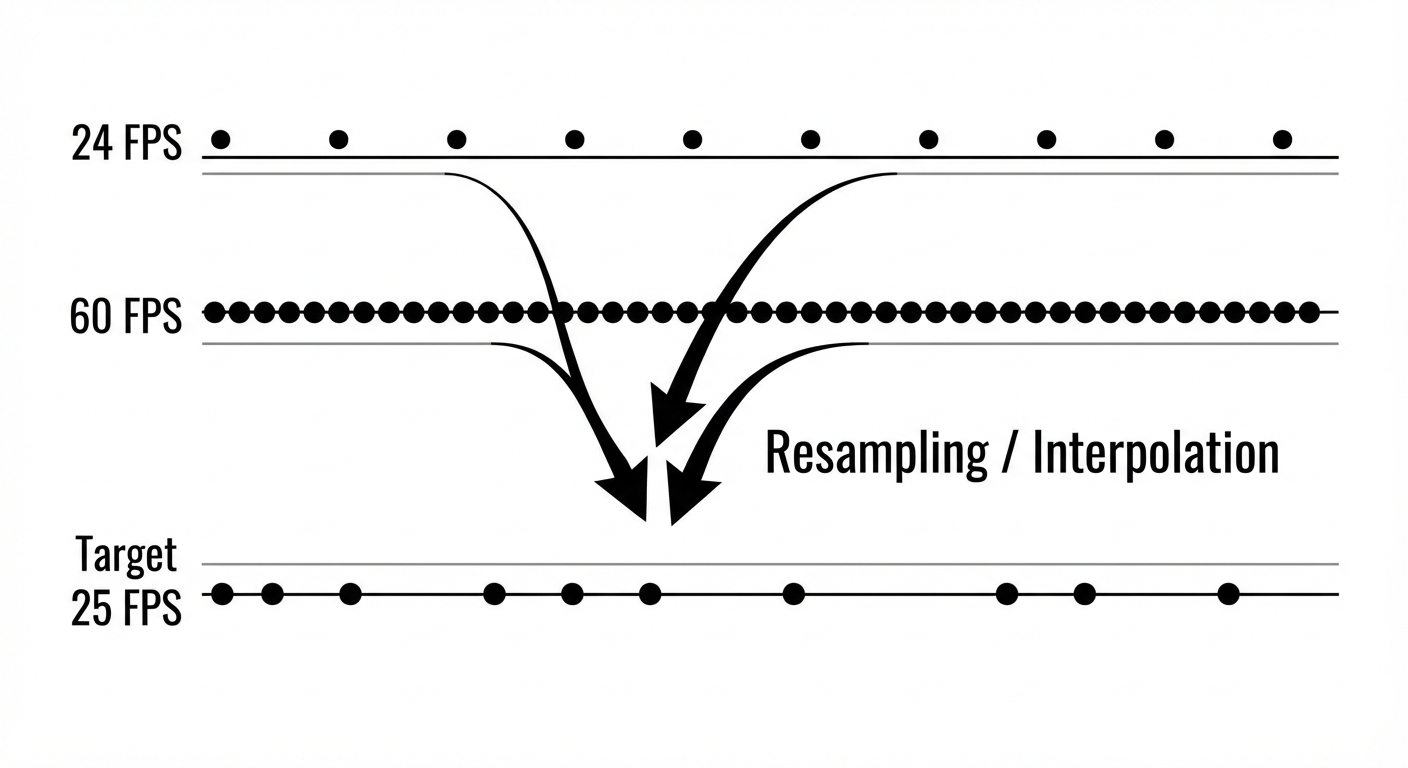

In [48]:
import numpy as np
from pose_format import Pose

In [49]:
pose_file_1 = '../data/pose_files/SGB_FSS_original.pose'
save_path = "../output/07_Interpolate/"

In [50]:

def load_pose(path: str) -> Pose:
    with open(path, 'rb') as f:
        return Pose.read(f.read())

def save_as_pose(pose: Pose, output_path: str):
    """
    Saves a Pose object to a .pose file.
    """
    with open(output_path, 'wb') as f:
        pose.write(f)
    print(f"✅ Saved to: {output_path}")

In [51]:
pose = load_pose(pose_file_1)
save_as_pose(pose, save_path + "loaded_pose.pose")

✅ Saved to: ../output/07_Interpolate/loaded_pose.pose


## Interpolation Methods

### Types of Interpolation:

**1. `'linear'`: Straight line between points**
- Fast
- Movement may appear choppy

**2. `'quadratic'`: Second-degree curve**
- Medium speed
- Smoother movement

**3. `'cubic'`: Third-degree curve**
- Slightly slower
- Very smooth movement (best for natural movements)

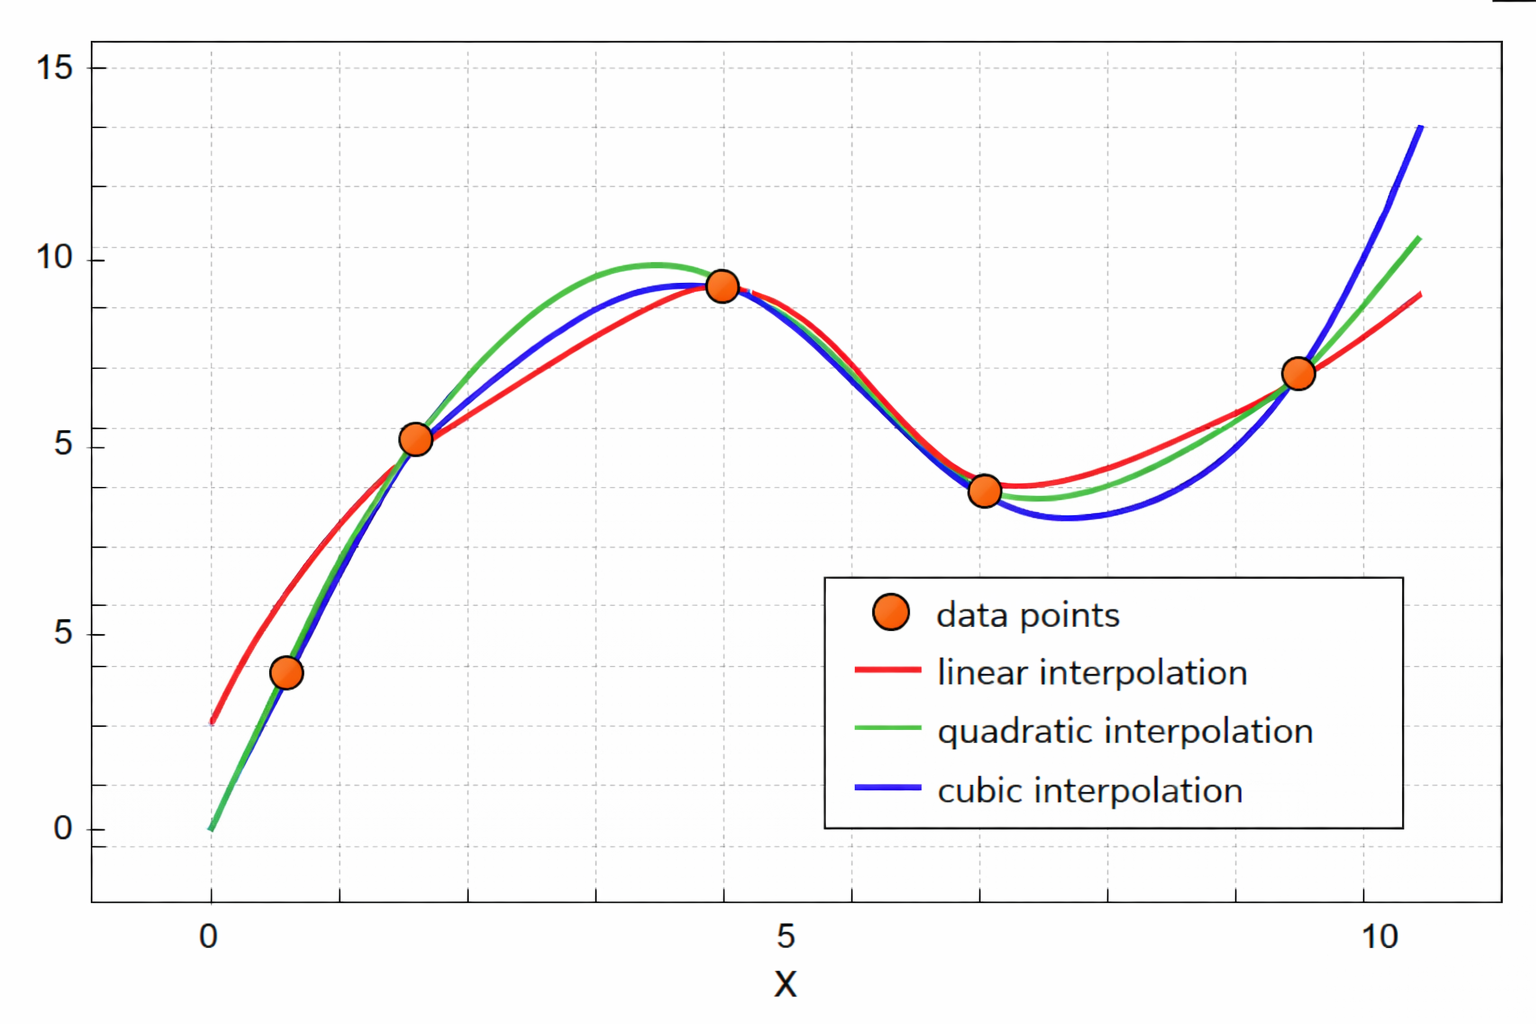

## Understanding `interpolate()` Function

### 1) Two Main Use Cases

#### A) Unifying/Changing FPS (Resampling)

When you execute:
```python
pose2 = pose.interpolate(new_fps=25, kind='cubic')
```

**This means:**
- You have a video with, for example, 30 FPS or 60 FPS
- You want it to be 25 FPS
- The library will "resample" the movement temporally:
  - **If reducing FPS:** Reduces the number of frames (while trying to maintain movement shape)
  - **If increasing FPS:** Adds new frames between old frames (computed frames)

#### B) Filling Missing Values Within the Same Frames (Fill Missing)

When you execute:
```python
pose2 = pose.interpolate(new_fps=None, kind='linear')
```

**The idea here is NOT to change FPS, but to:**
- Fill in points with missing values (usually NaN) because the detector couldn't see the hand/face in some frames
- `interpolate` fills the gaps between the last known value and the first known value after it

**Quick Example:**
- Frame 10: Wrist is present
- Frames 11–13: Wrist is hidden (NaN)
- Frame 14: Wrist reappears
- `interpolate` puts estimated values for frames 11–13 instead of NaN

---

### 2) What Does `kind` Mean (linear / quadratic / cubic)?

This is the "curve shape" used to place intermediate values:

- **`linear`**: Straight line between two points
  - Fast and simple, but movement may appear "angular"
- **`cubic`**: Smoother curve
  - Usually better for natural movement, but may "overshoot" if gaps are large

**Practical Rule:**
- **For filling missing frames:** Start with `linear` (safer)
- **For changing FPS and smoothing movement:** `cubic` is usually nice

---

### 3) Important Notes (Don't Be Surprised!)

- **Large Gaps:** If there's a very large gap (e.g., hand is hidden for 40 frames), interpolation may produce an unrealistic path because it's "imagining" the path between two distant points.

- **Confidence Values:** Interpolation works on coordinates, but confidence (if you have a separate confidence matrix) isn't always fixed with the same logic (depends on version). Sometimes it's better to filter/mask by confidence after interpolation.

- **Multiple People:** If you have more than one person (people>1), interpolation applies to each person/point.

---

### 4) Two Quick Examples in Your Project

**Unify all videos to 25 FPS:**
```python
pose = pose.interpolate(new_fps=25, kind='cubic')
```

**Clean NaN without changing FPS:**
```python
pose = pose.interpolate(new_fps=None, kind='linear')
```

**What is `interpolate` here?** A tool that lets you control the time axis—either change the frame density (FPS) or fill data gaps so training doesn't break from NaNs.

## 3️⃣ Unifying/Changing FPS (Resampling)

In [52]:
def change_fps(pose: Pose, new_fps: float, kind: str = 'cubic') -> Pose:
    """
    Change frame rate using interpolation
    
    Parameters:
    -----------
    new_fps : float
        New frame rate
    kind : str
        Interpolation type: 'linear', 'quadratic', 'cubic'
    """
    pose_copy = pose.copy()
    
    original_fps = pose_copy.body.fps
    original_frames = pose_copy.body.data.shape[0]
    
    interpolated = pose_copy.interpolate(new_fps=new_fps, kind=kind)
    
    new_frames = interpolated.body.data.shape[0]
    
    print(f"✅ FPS Changed")
    print(f"   From: {original_fps} FPS ({original_frames} frames)")
    print(f"   To: {new_fps} FPS ({new_frames} frames)")
    print(f"   Interpolation type: {kind}")
    
    return interpolated

In [53]:
print("Original Pose:")
print(f"Pose FPS: {int(pose.body.fps)} FPS")

Original Pose:
Pose FPS: 24 FPS


In [54]:
pose_5fps = change_fps(pose, new_fps=5 , kind='linear')
pose_10fps = change_fps(pose, new_fps=10 , kind='linear')
pose_15fps = change_fps(pose, new_fps=15 , kind='linear')

save_as_pose(pose_5fps, save_path + "pose_5fps_linear.pose")
save_as_pose(pose_10fps, save_path + "pose_10fps_linear.pose")
save_as_pose(pose_15fps, save_path + "pose_15fps_linear.pose")

print(f"Pose 15: {int(pose_15fps.body.fps)} FPS")
print(f"Pose 10: {int(pose_10fps.body.fps)} FPS")
print(f"Pose 5: {int(pose_5fps.body.fps)} FPS")

✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 5 FPS (28 frames)
   Interpolation type: linear
✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 10 FPS (55 frames)
   Interpolation type: linear
✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 15 FPS (83 frames)
   Interpolation type: linear
✅ Saved to: ../output/07_Interpolate/pose_5fps_linear.pose
✅ Saved to: ../output/07_Interpolate/pose_10fps_linear.pose
✅ Saved to: ../output/07_Interpolate/pose_15fps_linear.pose
Pose 15: 15 FPS
Pose 10: 10 FPS
Pose 5: 5 FPS


In [55]:
pose_5fps = change_fps(pose, new_fps=5 , kind='quadratic')
pose_10fps = change_fps(pose, new_fps=10 , kind='quadratic')
pose_15fps = change_fps(pose, new_fps=15 , kind='quadratic')

save_as_pose(pose_5fps, save_path + "pose_5fps_quadratic.pose")
save_as_pose(pose_10fps, save_path + "pose_10fps_quadratic.pose")
save_as_pose(pose_15fps, save_path + "pose_15fps_quadratic.pose")

print(f"Pose 15: {int(pose_15fps.body.fps)} FPS")
print(f"Pose 10: {int(pose_10fps.body.fps)} FPS")
print(f"Pose 5: {int(pose_5fps.body.fps)} FPS")

✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 5 FPS (28 frames)
   Interpolation type: quadratic
✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 10 FPS (55 frames)
   Interpolation type: quadratic
✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 15 FPS (83 frames)
   Interpolation type: quadratic
✅ Saved to: ../output/07_Interpolate/pose_5fps_quadratic.pose
✅ Saved to: ../output/07_Interpolate/pose_10fps_quadratic.pose
✅ Saved to: ../output/07_Interpolate/pose_15fps_quadratic.pose
Pose 15: 15 FPS
Pose 10: 10 FPS
Pose 5: 5 FPS


In [56]:
pose_5fps = change_fps(pose, new_fps=5 , kind='cubic')
pose_10fps = change_fps(pose, new_fps=10 , kind='cubic')
pose_15fps = change_fps(pose, new_fps=15 , kind='cubic')

save_as_pose(pose_5fps, save_path + "pose_5fps_cubic.pose")
save_as_pose(pose_10fps, save_path + "pose_10fps_cubic.pose")
save_as_pose(pose_15fps, save_path + "pose_15fps_cubic.pose")

print(f"Pose 15: {int(pose_15fps.body.fps)} FPS")
print(f"Pose 10: {int(pose_10fps.body.fps)} FPS")
print(f"Pose 5: {int(pose_5fps.body.fps)} FPS")

✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 5 FPS (28 frames)
   Interpolation type: cubic
✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 10 FPS (55 frames)
   Interpolation type: cubic
✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 15 FPS (83 frames)
   Interpolation type: cubic
✅ Saved to: ../output/07_Interpolate/pose_5fps_cubic.pose
✅ Saved to: ../output/07_Interpolate/pose_10fps_cubic.pose
✅ Saved to: ../output/07_Interpolate/pose_15fps_cubic.pose
Pose 15: 15 FPS
Pose 10: 10 FPS
Pose 5: 5 FPS


## Filling Missing Values Within the Same Frames (Fill Missing)

### When Do Missing Frames Occur?

```python
# Example: In some frames, the hand was not detected
frame 1: [x=0.5, y=0.3]  ✓ Hand detected
frame 2: [x=NaN, y=NaN]  ✗ Hand not detected (behind the body)
frame 3: [x=NaN, y=NaN]  ✗ Hand not detected
frame 4: [x=0.7, y=0.4]  ✓ Hand detected again
```

**The idea here is NOT to change FPS, but to:**
- Fill in points with missing values (usually NaN) because the detector couldn't see the hand/face in some frames
- `interpolate` fills the gaps between the last known value and the first known value after it


In [57]:
def interpolate_missing_frames(pose: Pose) -> Pose:
    """
    Fill missing frames using interpolation
    (Maintains the same FPS)
    """
    pose_copy = pose.copy()
    
    # Interpolation with the same FPS fills missing values
    interpolated = pose_copy.interpolate(new_fps=None, kind='linear')
    
    print("✅ Missing frames filled")
    return interpolated

In [58]:

pose_filled = interpolate_missing_frames(pose)
save_as_pose(pose_filled, save_path + "pose_filled.pose")

✅ Missing frames filled
✅ Saved to: ../output/07_Interpolate/pose_filled.pose


## Upsampling (Increasing FPS)

In [59]:

pose_30fps = change_fps(pose_5fps, new_fps=30, kind='cubic')
save_as_pose(pose_30fps, save_path + "pose_upsampled_5fps_to_30fps.pose")

print(f"Pose FPS: {int(pose_30fps.body.fps)} FPS")

✅ FPS Changed
   From: 5 FPS (28 frames)
   To: 30 FPS (168 frames)
   Interpolation type: cubic
✅ Saved to: ../output/07_Interpolate/pose_upsampled_5fps_to_30fps.pose
Pose FPS: 30 FPS


In [60]:
pose_15fps = change_fps(pose_5fps, new_fps=15, kind='cubic')
save_as_pose(pose_15fps, save_path + "pose_upsampled_5fps_to_15fps.pose")

print(f"Pose FPS: {int(pose_15fps.body.fps)} FPS")

✅ FPS Changed
   From: 5 FPS (28 frames)
   To: 15 FPS (84 frames)
   Interpolation type: cubic
✅ Saved to: ../output/07_Interpolate/pose_upsampled_5fps_to_15fps.pose
Pose FPS: 15 FPS


In [61]:
print("Original Pose:")
print(f"Pose FPS: {int(pose.body.fps)} FPS")

Original Pose:
Pose FPS: 24 FPS


In [62]:
pose_30fps = change_fps(pose, new_fps=30, kind='cubic')
save_as_pose(pose_30fps, save_path + "pose_upsampled_24fps_to_30fps.pose")

print(f"Pose FPS: {int(pose_30fps.body.fps)} FPS")

✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 30 FPS (165 frames)
   Interpolation type: cubic
✅ Saved to: ../output/07_Interpolate/pose_upsampled_24fps_to_30fps.pose
Pose FPS: 30 FPS


In [63]:
pose_60fps = change_fps(pose, new_fps=60, kind='cubic')
save_as_pose(pose_60fps, save_path + "pose_upsampled_24fps_to_60fps.pose")

print(f"Pose FPS: {int(pose_60fps.body.fps)} FPS")

✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 60 FPS (330 frames)
   Interpolation type: cubic
✅ Saved to: ../output/07_Interpolate/pose_upsampled_24fps_to_60fps.pose
Pose FPS: 60 FPS


In [64]:
pose_90fps = change_fps(pose, new_fps=90, kind='cubic')
save_as_pose(pose_90fps, save_path + "pose_upsampled_24fps_to_90fps.pose")

print(f"Pose FPS: {int(pose_90fps.body.fps)} FPS")

✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 90 FPS (495 frames)
   Interpolation type: cubic
✅ Saved to: ../output/07_Interpolate/pose_upsampled_24fps_to_90fps.pose
Pose FPS: 90 FPS


## Downsampling (Decreasing FPS)

In [65]:
pose_10fps = change_fps(pose, new_fps=10, kind='cubic')
save_as_pose(pose_10fps, save_path + "pose_downsampled_24fps_to_10fps.pose")

print(f"Pose FPS: {int(pose_10fps.body.fps)} FPS")

✅ FPS Changed
   From: 24.16666603088379 FPS (133 frames)
   To: 10 FPS (55 frames)
   Interpolation type: cubic
✅ Saved to: ../output/07_Interpolate/pose_downsampled_24fps_to_10fps.pose
Pose FPS: 10 FPS
